# Trade Execution - Predicting Shortfall

## Introduction
Within finance, an optimal trade execution strategy can enhance a portfolio’s performance
by using short-term expectations of stock price movements to optimally time a trade.
However, it is difficult to capture the idiosyncratic information surrounding stock price changes. Alpha profiling uses the past behavior of portfolio managers
(PMs) to learn patterns about trade execution costs.  

In this project, we aim to predict the deviations between actual and expected trade execution costs for a specific portfolio manager.

In [2]:
%matplotlib inline
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import scipy.stats as sps

from edward.models import Bernoulli, MultivariateNormalTriL, Normal, Gamma
from edward.util import rbf

plt.style.use('ggplot')

In [3]:
ed.set_seed(42)

## Data Overview

The dataset is comprised of the following columns:

* Implementation Shortfall (bps) - $\mathbb{R}$
* Expected Cost (bps) - $\mathbb{R}_+$
* Trade Amount (\$) - $\mathbb{R}$
* Forecast Participation Rate (%) - $\mathbb{R}_+$
* Stock Volatility: 5 day, 15 day - $\mathbb{R}_+$
* Momentum: Open, 5 Day, 15 Day - $\mathbb{R}$
    
The goal is to predict the deviation between implementation shortfall (actual cost) and expected costs. These deviations are largely influenced by underlying price changes in the market. The prediction model is split into two components: direction and magnitude.

<b>Direction</b>

This is a classification problem that will determine whether the deviation is positive or not. A positive deviation indicates that the execution cost is more expensive than predicted. These deviations are mostly driven by short-term price moves. 

<b>Magnitude</b>

This is a regression problem, which predicts the absolute deviation size. This is largely dependent on trade size, security volatility, and momentum. It isalso influenced by idiosynractic events, which are not covered here.

Number of data points: 911
Number of features: 7


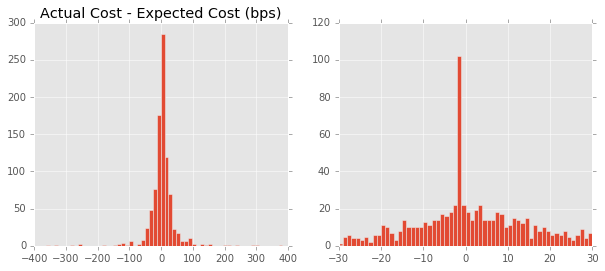

In [4]:
data = np.loadtxt('data/train_data.csv', delimiter=',',skiprows=1)

# Data Size
N = data.shape[0]  # number of data points
D_size = data.shape[1]-2  # number of magnitude features
D_dir = data.shape[1]-2  # number of size features
print("Number of data points: {}".format(N))
print("Number of features: {}".format(D_size))

# Cost Deviation: IS - EC
y_train = data[:, 0]-data[:,1]

# Histograms of y variable
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Actual Cost - Expected Cost (bps)')
_ = plt.hist(y_train,bins=60)
plt.subplot(1,2,2)
_ = plt.hist(y_train,bins=60,range=(-30, 30))

## 1a. Magnitude - Bayesian Linear Regression

Here, we aim to predict how large the deviation between actual and expected costs will be. Because we aren't focused on the direction, we will look only at the absolute value of the variables. This emphasizes the idea that, on an absolute basis, larger values within explanatory variables should result in larger deviations.

### Data

In [5]:
# Magnitude Training Data
X_train_size = np.absolute(data[:, 2:])
y_train_size = np.absolute(data[:, 0]-data[:,1])


### Model - Bayesian Linear Regression

Initial testing with a GP model resulted in kernels that were not positive definite due to the large feature and sample size. Instead, we start with a linear regression model.

The linear regression model has the following form, with weights $w$ and coefficient $b$ latent variables and assumed known variances 1:

$$p(w)=Normal(w \mid 0,1)$$
$$p(b)=Normal(b \mid 0,1)$$
$$p(y \mid w, b, X)= \prod_{n=1}^N Normal(y_n \mid {x_n}^Tw+b,1)$$

In [6]:
X_size = tf.placeholder(tf.float32, [N, D_size]) 
w_size = Normal(loc=tf.zeros(D_size), scale=tf.ones(D_size)) 
b_size = Normal(loc=tf.zeros(1), scale=tf.ones(1)) 
y_size = Normal(loc=ed.dot(X_size, w_size) + b_size, scale=tf.ones(N))

### Inference

We will use Kullbck-Leibler divergence to learn the weights and intercept of the regression. KLqp is a non-symmetrical variational inference algorithm that seeks to approximate the posterior by optimizing the distribution's parameters. It does this by minimizing the divergence of two distributions: the observed and the parameterized theoretical. Versus MCMC, variational inference tends to be faster and more scalable. This will become important in later on.

In [7]:
qw = Normal(loc=tf.Variable(tf.random_normal([D_size])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D_size]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

inference_1 = ed.KLqp({w_size: qw, b_size: qb}, 
                      data={X_size: X_train_size, y_size: y_train_size})
inference_1.initialize(n_iter=10000)

{'t': 1, 'loss': 7.3910004e+15}
{'t': 2001, 'loss': 2.198408e+14}
{'t': 4001, 'loss': 5.9436517e+12}
{'t': 6001, 'loss': 3.6871531e+13}
{'t': 8001, 'loss': 8.2995603e+12}


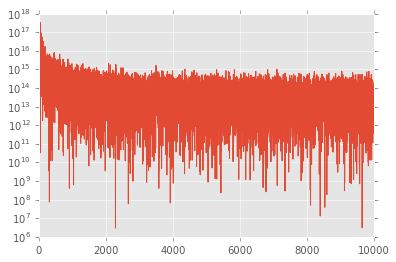

In [8]:
sess_1 = ed.get_session()
init_1 = tf.global_variables_initializer()
init_1.run()
curve = []
for _ in range(inference_1.n_iter):
    status_1 = inference_1.update()
    if _%2000 == 0:
        print(status_1)
    curve.append(status_1['loss'])
_=plt.semilogy(curve)

### Criticism

This model has difficulty converging under KLQP (shown) as well as other inference algorithms. As expected, the mean absolute error is high.

In [9]:
y_post_size_1 = ed.copy(y_size,{w_size: qw, b_size: qb})

In [10]:
print("Mean Absolute Error on Training Data")
ed.evaluate('mean_absolute_error', data={y_post_size_1: y_train_size, X_size: X_train_size})

Mean Absolute Error on Training Data


5359.6606

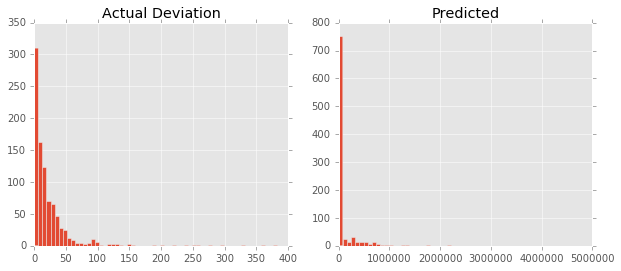

In [11]:
test_1=y_post_size_1.eval(feed_dict={X_size: X_train_size})

plt.figure(figsize=(10,4))
ax1=plt.subplot(1,2,1)
plt.title('Actual Deviation')
_ = plt.hist(y_train_size,bins=60)
plt.subplot(1,2,2)
plt.title('Predicted')
_ = plt.hist(test_1,bins=60)

## 1b. Magnitude - Gamma Regression

The issue is likely due to the assumption that the y variable is normally distributed. As we see above, it may make more sense to use a gamma or lognormal distribution rather than a linear regression.

In [12]:
X_train_size_2 = np.absolute(data[:, 2:])
y_train_size_2 = np.absolute(data[:, 0]-data[:,1])


### Model

The gamma distribution is defined over positive real numbers, with parameters $\alpha$ and $\beta$ and normalizing constant $C$, as follows:

$$ y_{i} = Gamma(\alpha,\beta) = \frac{1}{C}x^{\alpha-1}\exp{(-x \beta)} $$ 

$$\text{with} $$

$$ E(y_{i}) = \frac{\alpha}{\beta} \text{ and } Var(y_{i}) = \frac{\alpha}{\beta^2}  $$ 

As $\alpha$ and $\beta$ need to be positive real numbers, we can define them as the exponential of variables $\nu_0$ and $\nu_1$ that follow a normal distribution.


In [13]:
X_size_2 = tf.placeholder(tf.float32, [N, D_size])
nu0 = Normal(loc=tf.ones(1), scale=tf.ones(1))
nu1 = Normal(loc=tf.ones(1), scale=tf.ones(1))

alpha = tf.exp(nu0)
beta = tf.exp(nu1)

y_size_2 = Gamma(concentration=tf.ones(N)*alpha, rate=tf.ones(N)*beta)


### Inference

Run KLqp on $\nu_0$ and $\nu_1$.

In [14]:
qnu0 = Normal(loc=tf.Variable(tf.random_normal([1])), 
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qnu1 = Normal(loc=tf.Variable(tf.random_normal([1])), 
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

inference_2 = ed.KLqp({nu0: qnu0, nu1: qnu1}, 
                      data={X_size_2: X_train_size_2, y_size_2: y_train_size_2})
inference_2.initialize(n_iter=10000)

{'t': 1, 'loss': 10895.33}
{'t': 2001, 'loss': 3737.0022}
{'t': 4001, 'loss': 3738.6167}
{'t': 6001, 'loss': 3737.3462}
{'t': 8001, 'loss': 3737.5256}


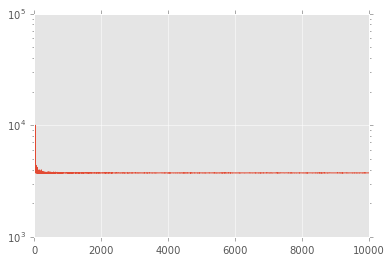

In [15]:
sess_2 = ed.get_session()
init_2 = tf.global_variables_initializer()
init_2.run()
curve = []
for _ in range(inference_2.n_iter):
    status_2 = inference_2.update()
    if _%2000 == 0:
        print(status_2)
    curve.append(status_2['loss'])
_=plt.semilogy(curve)

In [16]:
y_post_size_2 = ed.copy(y_size_2,{nu0: qnu0, nu1: qnu1})

In [17]:
print("Mean Absolute Error on Training Data")
ed.evaluate('mean_absolute_error', data={y_post_size_2: y_train_size_2, X_size_2: X_train_size_2})

Mean Absolute Error on Training Data


20.75313

In [18]:
print("Std Dev of Actual Data")
print(np.sqrt(np.var(y_train_size_2)))

Std Dev of Actual Data
38.3814065033


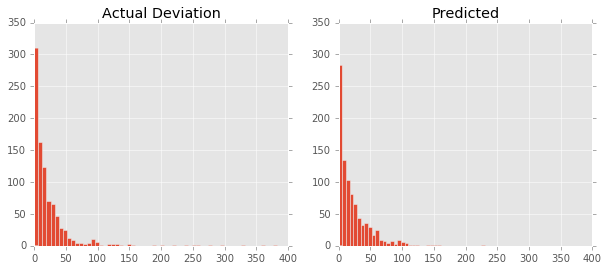

In [19]:
test_2=y_post_size_2.eval(feed_dict={X_size_2: X_train_size_2})

plt.figure(figsize=(10,4))
ax1=plt.subplot(1,2,1)
plt.title('Actual Deviation')
_ = plt.hist(y_train_size_2,bins=60)
plt.subplot(1,2,2,sharex=ax1, sharey=ax1)
plt.title('Predicted')
_ = plt.hist(test_2, bins=40)

## 2a. Direction - Momentum Only

Momentum is the rate of acceleration in a stock's price. The philosophy behind momentum investing is that stock's the are performing well will continue to perform well. As such, momentum can be an indicator of the direction of short-term price moves.

### Data




In [20]:
X_train_dir_1 = data[:, 6:]
y_train_dir_1 = data[:, 0]-data[:,1]
# Convert to Classification
y_train_dir_1[y_train_dir_1[:] > 0] = 1  
y_train_dir_1[y_train_dir_1[:] < 0] = 0

D_dir_1 = X_train_dir_1.shape[1]
print("Number of features: {}".format(D_dir_1))

Number of features: 3


### Model - GP Classification

A Gaussian Process is a flexible model with a prior that defines functions as smooth and random variables as joint Gaussian distributions (Rasmussen and Williams, 2006). It allows for the relaxation of assumptions surrounding linearity and distributions.

The likelihood for a GP is defined as:

$$p(y)=Normal(y \mid 0,K)$$

where K is the covariance matrix evaluated by the rdf kernel. The radial-basis function kernel, or squared-exponential kernel, is a stationary kernel of the form:

$$k(x, x') = \sigma^2 exp(-\frac{1}{2} \sum_{d=1}^{D} \frac{1}{{l_d}^2} {(x_d-x'_d)}^2)$$

with length-scale parameter $l_d > 0$ and output variance $\sigma^2$. This kernel is infinitely differentiable, which promotes smoothness.

To convert this into a classification problem, we define a multivariate normal prior and Bernoulli likelhood:

$$p(z)=Normal(z\mid 0,K)$$

$$p(y_n \mid z, x_n)=Bernoulli(y_n\mid logit^{-1}(z_n))$$


In order to parameterize the multivariate normal, we use a Cholesky decomposition of the kernel matrix, which requires a positive definite matrix. In order to correct for numerical errors that cause small, negative eigenvalues, we add a small constant to the diagonal of the kernel.


In [21]:
X_dir_1 = tf.placeholder(tf.float32, [N, D_dir_1])
f_dir_1 = MultivariateNormalTriL(loc=tf.zeros(N), 
                                 scale_tril=tf.cholesky(rbf(X_dir_1)+0.00001*np.eye(N)))
y_dir_1 = Bernoulli(logits=f_dir_1)

### Inference

For inference, we run KLqp across the function space f.

In [22]:
qf_dir_1 = Normal(loc=tf.Variable(tf.random_normal([N])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N]))))

inference_dir_1 = ed.KLqp({f_dir_1: qf_dir_1}, 
                          data={X_dir_1: X_train_dir_1, y_dir_1: y_train_dir_1})
inference_dir_1.initialize(n_iter=10000)

{'t': 1, 'loss': 94509296.0}
{'t': 2001, 'loss': 36050.762}
{'t': 4001, 'loss': 19824.6}
{'t': 6001, 'loss': 18935.313}
{'t': 8001, 'loss': 17264.281}


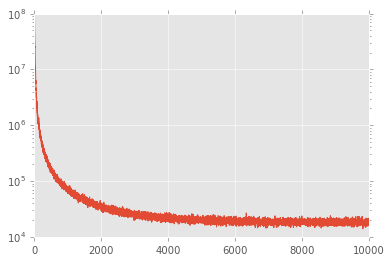

In [23]:
sess_3 = ed.get_session()
init_3 = tf.global_variables_initializer()
init_3.run()
curve = []
for _ in range(inference_dir_1.n_iter):
    status_3 = inference_dir_1.update()
    if _%2000 == 0:
        print(status_3)
    curve.append(status_3['loss'])
_=plt.semilogy(curve)

### Criticism

In [24]:
y_post_dir_1 = ed.copy(y_dir_1,{f_dir_1:qf_dir_1})

In [25]:
print("Categorical Accuracy on Training Data")
ed.evaluate('categorical_accuracy', data={y_post_dir_1: y_train_dir_1, X_dir_1: X_train_dir_1})

Categorical Accuracy on Training Data


0.50933039

By randomly guessing, we have a 50% chance  of classifying the direction correctly. Is something missing from the model?

## 2b. Direction - Momentum and Trade Type (Buy/Sell)

We now introduce information about the trade type, where a 1 indicates buying and -1 indicates selling. This feature is important because the impact of stock price movements is different depending on if you're buying or selling. We can easily add categorical variables into GP given its flexible structure.

### Data




In [32]:
X_train_dir_2 = data[:, 2:6:]
y_train_dir_2 = data[:, 0]-data[:,1]
# Convert Y to classification
y_train_dir_2[y_train_dir_2[:] > 0] = 1  
y_train_dir_2[y_train_dir_2[:] < 0] = 0
# Convert Trade Amount to Buy/Sell
X_train_dir_2[X_train_dir_2[:,0] > 0,0] = 1
X_train_dir_2[X_train_dir_2[:,0] < 0,0] = -1
D_dir_2 = X_train_dir_2.shape[1]
print("Number of features: {}".format(D_dir_2))

Number of features: 4


### Model & Inference

We use the same model and inference assumptions and add the trade type feature.

In [33]:
X_dir_2 = tf.placeholder(tf.float32, [N, D_dir_2])
f_dir_2 = MultivariateNormalTriL(loc=tf.zeros(N), 
                                 scale_tril=tf.cholesky(rbf(X_dir_2)+0.0001*np.eye(N)))
y_dir_2 = Bernoulli(logits=f_dir_2)

In [34]:
qf_dir_2 = Normal(loc=tf.Variable(tf.random_normal([N])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N]))))

inference_dir_2 = ed.KLqp({f_dir_2: qf_dir_2}, 
                          data={X_dir_2: X_train_dir_2, y_dir_2: y_train_dir_2})
inference_dir_2.initialize(n_iter=10000)

{'t': 1, 'loss': 7229973.5}
{'t': 2001, 'loss': 2131.3628}
{'t': 4001, 'loss': 1635.1975}
{'t': 6001, 'loss': 1505.8467}
{'t': 8001, 'loss': 1390.1458}


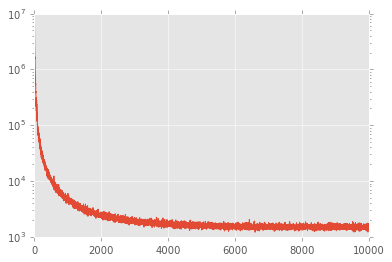

In [36]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
curve = []
for _ in range(inference_dir_2.n_iter):
    status = inference_dir_2.update()
    if _%2000 == 0:
        print(status)
    curve.append(status['loss'])
_=plt.semilogy(curve)

### Criticism

In [37]:
y_post_dir_2 = ed.copy(y_dir_2,{f_dir_2:qf_dir_2})

In [38]:
print("Categorical Accuracy on Training Data")
ed.evaluate('categorical_accuracy', data={y_post_dir_2: y_train_dir_2, X_dir_2: X_train_dir_2})

Categorical Accuracy on Training Data


0.83315039

The accuracy of the posterior is now much higher, around 80-85%.